### Make paths to directories

In [1]:
import sys
import os

# Get the path to the current working directory
current_dir = os.getcwd()

# Get the path to the parent directory (containing both A.py and 'B' directory)
parent_dir = os.path.dirname(current_dir)

Irish_data_dir = os.path.join(parent_dir, 'Data/Irish_dataset/preprocessed')
results_dir = os.path.join(current_dir, 'resultsIreland')
# Append the parent directory to the module search path
sys.path.append(parent_dir)
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator


### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator
from data_preprocessing.get_buffer_attributes import BufferAttributesCalculator

import numpy as np
import pandas as pd
import pickle
import datetime
import inspect
from pathlib import Path


### DATA generators

In [4]:
def season_from_date(date):
    month = date.month
    if 3 <= month <= 5:
        return 2
    elif 6 <= month <= 8:
        return 3
    elif 9 <= month <= 11:
        return 1
    return 4

In [5]:
random_gen = np.random.default_rng(12341)

def random_dataset(N):
    attributes = random_gen.random(size = (N, 25))
    timeseries = random_gen.random(size = (N, 24*4))
    folds = np.array_split(np.arange(0, N, dtype= 'int'), 5)
    return attributes, timeseries, folds

def london_dataset(london_data_dir=Irish_data_dir, attributes = "combined_attributes_filtered.pkl", timeseries = "daily_data_df_filtered.pkl"):
    #return [], [], []
    attributes_path = os.path.join(london_data_dir, attributes)
    timeseries_path = os.path.join(london_data_dir, timeseries)
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)
    folds = np.array_split(np.arange(0, len(attributes), dtype= 'int'), 5)

    return attributes, timeseries, folds

def london_dataset_with_buffer(buffer_attributes, startdate = pd.to_datetime('2010-05-01'), london_data_dir = Irish_data_dir, attributes = "combined_attributes_filtered.pkl", timeseries = "daily_data_df_filtered.pkl", weekdays_only = True):
    
    return [], [], []

    attributes_path = os.path.join(london_data_dir, attributes) #combined_attributes_filtered.pkl
    buffer_attributes_path = os.path.join(london_data_dir, buffer_attributes) #daily_data_df_filtered.pkl
    timeseries_path = os.path.join(london_data_dir, timeseries) #buffer_attributes_march_df.pkl
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)
    buffer_attributes = pd.read_pickle(buffer_attributes_path)
    merged_attributes = attributes.merge(buffer_attributes,on=['meterID'], how="left")

    merged_attributes = merged_attributes.drop(columns=['kurtosis_weekend','skewness_weekend'])
    # Assuming timeseries and attributes are your DataFrames
    # Extract the date part from the MultiIndex of timeseries
    dates = timeseries.index.get_level_values(1)

    # Replace '1' with the correct level if different
    dates = pd.to_datetime(dates)
    # Calculate the difference in days from January 1st, 2010
    start_date = startdate
    days_diff = (dates - start_date).days

    # Add this information to the attributes DataFrame
    # Assuming the order and length of rows in both DataFrames are the same
    merged_attributes['TimeFromBuffer'] = days_diff
    season = season_from_date(start_date)
    merged_attributes['sameseason'] = merged_attributes['season'] == season
    to_drop = get_meterids_with_NaNs(merged_attributes)
    merged_attributes = merged_attributes.drop(index=to_drop)
    timeseries = timeseries.drop(index=to_drop)
    print(to_drop)
    folds = np.array_split(np.arange(0, len(merged_attributes), dtype= 'int'), 5)

    return merged_attributes, timeseries, folds

In [6]:
def get_NaNs(df):
    NaN_counts = df.isna().sum()
    for column_name, na_count in NaN_counts.items():
        if na_count > 0:
            print(f"Column {column_name} has {na_count} missing values.")
 

In [7]:
def get_meterids_with_NaNs(df):
    meterids_with_nans = set()
    for meterid, row in df.iterrows():
        if row.isna().any():
            meterids_with_nans.add(meterid)
    return meterids_with_nans



# Parameter Tuning

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsIreland/Tuning'), nb_of_samples = 250)
    .add_methods(
        PCT_D6_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 100)),
        PCT_D8_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 100)),
        PCT_D10_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 100)),
        PCT_D6_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 175)),
        PCT_D8_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 175)),
        PCT_D10_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 175)),
        PCT_D6_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 250)),
        PCT_D8_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 250)),
        PCT_D10_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 250)),
        PCT_D12_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 250)),
        PCT_D12_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 350)),
        PCT_D8_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 350)),
        




    )
    .add_datasets(
       
        ireland_dataset_baseline = london_dataset(),        
        )
)

energy_scores, timing_df = experiment.execute()

Methods: 100%|██████████| 12/12 [00:01<00:00,  7.82it/s, method=PCT_D8_M350]


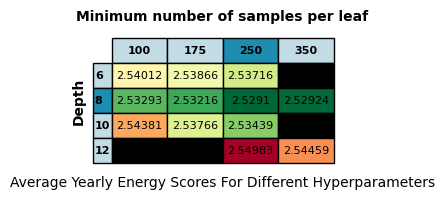

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

mean_es = energy_scores.mean(axis=0).to_frame('ES')
sorted_es = mean_es.sort_values(by='ES')
# Reset index to convert MultiIndex to columns
sorted_es_reset = sorted_es.reset_index()

# Extract Depth and Minimum number of samples from the 'level_0' column
depth_values = sorted_es_reset['level_0'].str.extract(r'D(\d+)_M(\d+)')
sorted_es_reset['Depth'] = depth_values[0].astype(int)
sorted_es_reset['Min_Samples'] = depth_values[1].astype(int)

# Pivot the DataFrame
pivot_df = sorted_es_reset.pivot(index='Depth', columns='Min_Samples', values='ES')

# Sort the index and columns for better readability
pivot_df = pivot_df.sort_index().sort_index(axis=1)

# Round the values to 5 decimal places
pivot_df = pivot_df.round(5)

# Create a normalized version of the DataFrame for colormap
norm = Normalize(vmin=pivot_df.min().min(), vmax=pivot_df.max().max())

# Create the plot and table
fig, ax = plt.subplots(figsize=(2.8, 2))  # Adjust figsize to fit your content
ax.axis('tight')
ax.axis('off')

# Create the table with the heatmap colors
heatmap_colors = plt.cm.RdYlGn_r(norm(pivot_df.values))

# Overwrite the colors for NaN values with black
nan_color = np.array([0, 0, 0, 1])  # RGBA for black
heatmap_colors[np.isnan(pivot_df.values)] = nan_color

# Find the cell with the minimum value
min_val_location = np.unravel_index(np.nanargmin(pivot_df.values), pivot_df.shape)
min_val_depth = pivot_df.index[min_val_location[0]]
min_val_min_samples = pivot_df.columns[min_val_location[1]]

# Get the color for the minimum value
min_val_color = plt.cm.RdYlGn_r(norm(pivot_df.min().min()))

# Create the table
table = ax.table(cellText=pivot_df.values,
                 cellColours=heatmap_colors,
                 colLabels=pivot_df.columns,
                 rowLabels=pivot_df.index,
                 cellLoc='center',
                 loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)  # Scale columns by 1.2 and rows by 1.5

# Adjust the position of the table
table.auto_set_column_width(col=list(range(len(pivot_df.columns))))

# Add text annotations for row and column labels
plt.text(-0.13, 0.5, 'Depth', va='center', ha='right', fontsize=10, fontweight='bold', transform=ax.transAxes, rotation=90)
plt.text(0.5, 1, 'Minimum number of samples per leaf', va='bottom', ha='center', fontsize=10, fontweight='bold', transform=ax.transAxes)
plt.text(0.5, -0.08, 'Average Yearly Energy Scores For Different Hyperparameters', va='bottom', ha='center', fontsize=10, transform=ax.transAxes)

base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)
# Update the font properties for the row and column labels in the table
for key, cell in table.get_celld().items():
    if key[0] == 0 or key[1] == -1:  # Column labels or Row labels
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor(palette[3])  # Set background color for row and column labels

# Highlight the row and column labels for the minimum value
for key, cell in table.get_celld().items():
    if key[0] == 0 and key[1] == min_val_location[1] :  # Column labels for min value
        cell.set_facecolor(palette[14])
    if key[1] == -1 and key[0] == min_val_location[0] + 1:  # Row labels for min value
        cell.set_facecolor(palette[14])

# Save the table as a PNG file with a transparent background
plt.savefig('pictures/tuningbaselineireland.png', bbox_inches='tight', dpi=300, transparent=True)

# Display the plot
plt.show()


In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsIreland/Tuning'), nb_of_samples = 250)
    .add_methods(
        PCT_D10_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 250)),
        PCT_D12_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 250)),
        PCT_D8_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 350)),
        PCT_D9_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 9, min_samples_leaf = 350)),
        PCT_D9_M450 = PredClusGenerator(DecisionTreeRegressor(max_depth = 9, min_samples_leaf = 450)),
        PCT_D9_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 9, min_samples_leaf = 450)),
    )
    .add_datasets(
        london_dataset_with_buffer_feb = london_dataset_with_buffer('buffer_attributes_month_2_all_catch22_df.pkl',pd.to_datetime('2010-02-01')),
        )
)

energy_scores, timing_df = experiment.execute()





Methods:   0%|          | 0/6 [00:00<?, ?it/s]

Methods: 100%|██████████| 6/6 [00:01<00:00,  5.41it/s, method=PCT_D9_M250] 


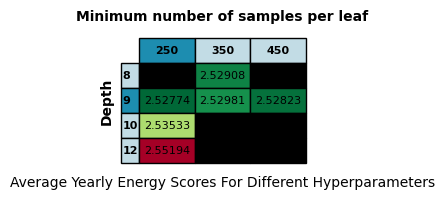

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

mean_es = energy_scores.mean(axis=0).to_frame('ES')
sorted_es = mean_es.sort_values(by='ES')
# Reset index to convert MultiIndex to columns
sorted_es_reset = sorted_es.reset_index()

# Extract Depth and Minimum number of samples from the 'level_0' column
depth_values = sorted_es_reset['level_0'].str.extract(r'D(\d+)_M(\d+)')
sorted_es_reset['Depth'] = depth_values[0].astype(int)
sorted_es_reset['Min_Samples'] = depth_values[1].astype(int)

# Pivot the DataFrame
pivot_df = sorted_es_reset.pivot(index='Depth', columns='Min_Samples', values='ES')

# Sort the index and columns for better readability
pivot_df = pivot_df.sort_index().sort_index(axis=1)

# Round the values to 5 decimal places
pivot_df = pivot_df.round(5)

# Create a normalized version of the DataFrame for colormap
norm = Normalize(vmin=pivot_df.min().min(), vmax=pivot_df.max().max())

# Create the plot and table
fig, ax = plt.subplots(figsize=(2.8, 2))  # Adjust figsize to fit your content
ax.axis('tight')
ax.axis('off')

# Create the table with the heatmap colors
heatmap_colors = plt.cm.RdYlGn_r(norm(pivot_df.values))

# Overwrite the colors for NaN values with black
nan_color = np.array([0, 0, 0, 1])  # RGBA for black
heatmap_colors[np.isnan(pivot_df.values)] = nan_color

# Find the cell with the minimum value
min_val_location = np.unravel_index(np.nanargmin(pivot_df.values), pivot_df.shape)
min_val_depth = pivot_df.index[min_val_location[0]]
min_val_min_samples = pivot_df.columns[min_val_location[1]]

# Get the color for the minimum value
min_val_color = plt.cm.RdYlGn_r(norm(pivot_df.min().min()))

# Create the table
table = ax.table(cellText=pivot_df.values,
                 cellColours=heatmap_colors,
                 colLabels=pivot_df.columns,
                 rowLabels=pivot_df.index,
                 cellLoc='center',
                 loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)  # Scale columns by 1.2 and rows by 1.5

# Adjust the position of the table
table.auto_set_column_width(col=list(range(len(pivot_df.columns))))

# Add text annotations for row and column labels
plt.text(0, 0.5, 'Depth', va='center', ha='right', fontsize=10, fontweight='bold', transform=ax.transAxes, rotation=90)
plt.text(0.5, 1, 'Minimum number of samples per leaf', va='bottom', ha='center', fontsize=10, fontweight='bold', transform=ax.transAxes)
plt.text(0.5, -0.08, 'Average Yearly Energy Scores For Different Hyperparameters', va='bottom', ha='center', fontsize=10, transform=ax.transAxes)

base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)
# Update the font properties for the row and column labels in the table
for key, cell in table.get_celld().items():
    if key[0] == 0 or key[1] == -1:  # Column labels or Row labels
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor(palette[3])  # Set background color for row and column labels

# Highlight the row and column labels for the minimum value
for key, cell in table.get_celld().items():
    if key[0] == 0 and key[1] == min_val_location[1] :  # Column labels for min value
        cell.set_facecolor(palette[14])
    if key[1] == -1 and key[0] == min_val_location[0] + 1:  # Row labels for min value
        cell.set_facecolor(palette[14])

# Save the table as a PNG file with a transparent background
plt.savefig('pictures/tuningbufferireland.png', bbox_inches='tight', dpi=300, transparent=True)

# Display the plot
plt.show()


# Final Experiment

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsIreland/ThesisResults'), nb_of_samples = 250)
    .add_methods(
        Random_Baseline = RandomGenerator(),
        PCT_D8_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 250)),

    )
    .add_datasets(
        london_dataset_baseline = london_dataset(),
    )
)

energy_scores, timing_df = experiment.execute()

Methods: 100%|██████████| 2/2 [00:00<00:00, 14.99it/s, method=PCT_D8_M250]


In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsIreland/ThesisResults'), nb_of_samples = 250)
    .add_methods(
        PCT_D9_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 9, min_samples_leaf = 250)),

    )
    .add_datasets(
        london_dataset_with_buffer_jan = london_dataset_with_buffer('buffer_attributes_month_1_all_catch22_df.pkl',pd.to_datetime('2010-01-01')),
        london_dataset_with_buffer_feb = london_dataset_with_buffer('buffer_attributes_month_2_all_catch22_df.pkl',pd.to_datetime('2010-02-01')),
        london_dataset_with_buffer_mar = london_dataset_with_buffer('buffer_attributes_month_3_all_catch22_df.pkl',pd.to_datetime('2010-03-01')),
        london_dataset_with_buffer_apr = london_dataset_with_buffer('buffer_attributes_month_4_all_catch22_df.pkl',pd.to_datetime('2010-04-01')),
        london_dataset_with_buffer_may = london_dataset_with_buffer('buffer_attributes_month_5_all_catch22_df.pkl',pd.to_datetime('2010-05-01')),
        london_dataset_with_buffer_jun = london_dataset_with_buffer('buffer_attributes_month_6_all_catch22_df.pkl',pd.to_datetime('2010-06-01')),
        london_dataset_with_buffer_jul = london_dataset_with_buffer('buffer_attributes_month_7_all_catch22_df.pkl',pd.to_datetime('2010-07-01')),
        london_dataset_with_buffer_aug = london_dataset_with_buffer('buffer_attributes_month_8_all_catch22_df.pkl',pd.to_datetime('2010-08-01')),
        london_dataset_with_buffer_sep = london_dataset_with_buffer('buffer_attributes_month_9_all_catch22_df.pkl',pd.to_datetime('2010-09-01')),
        london_dataset_with_buffer_oct = london_dataset_with_buffer('buffer_attributes_month_10_all_catch22_df.pkl',pd.to_datetime('2010-10-01')),
        london_dataset_with_buffer_nov = london_dataset_with_buffer('buffer_attributes_month_11_all_catch22_df.pkl',pd.to_datetime('2010-11-01')),
        london_dataset_with_buffer_dec = london_dataset_with_buffer('buffer_attributes_month_12_all_catch22_df.pkl',pd.to_datetime('2010-12-01')),
        )
)

energy_scores2, timing_df2 = experiment.execute()
energy_scores = pd.concat([energy_scores, energy_scores2], axis=1)


Methods: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, method=PCT_D9_M250]


In [20]:
mean_es = energy_scores.mean(axis=0).to_frame('ES')
sorted_es = mean_es.sort_values(by='ES')
display(sorted_es)

ES
PCT_D8_M250     london_dataset_baseline         2.529406
PCT_D9_M250     london_dataset_with_buffer_nov  2.531084
                london_dataset_with_buffer_feb  2.531142
                london_dataset_with_buffer_jan  2.532004
                london_dataset_with_buffer_oct  2.532178
                london_dataset_with_buffer_aug  2.532346
                london_dataset_with_buffer_jul  2.532970
                london_dataset_with_buffer_dec  2.533443
                london_dataset_with_buffer_jun  2.533881
                london_dataset_with_buffer_mar  2.534285
                london_dataset_with_buffer_sep  2.534384
                london_dataset_with_buffer_apr  2.534670
                london_dataset_with_buffer_may  2.535563
Random_Baseline london_dataset_baseline         2.867074

In [21]:
ldf = london_dataset()
merged_attributes, timeseries, folds = ldf
energy_scores.index = timeseries.index
energy_scores = energy_scores.droplevel('meterID')

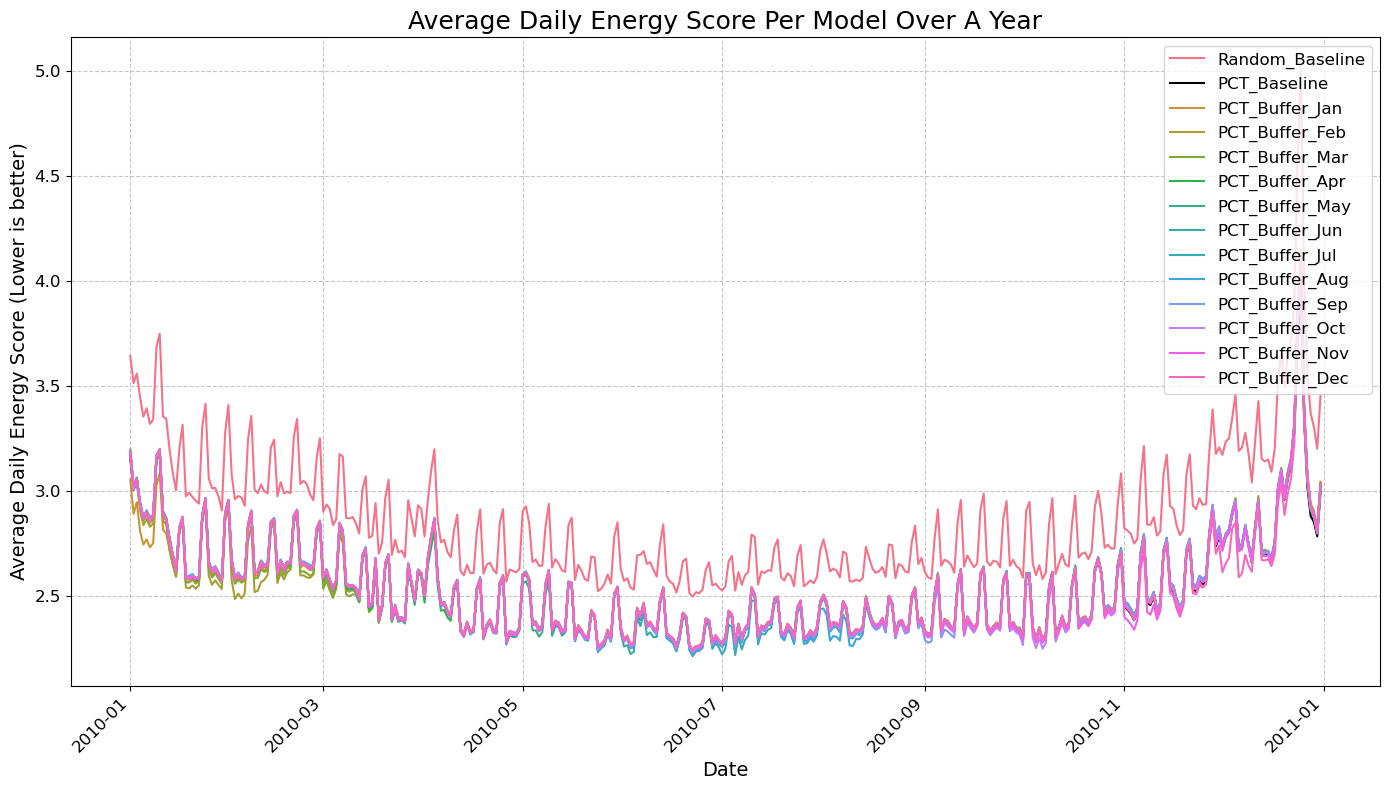

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'date' and calculate the mean and standard deviation for each day
df_avg = energy_scores.groupby('date').mean()
# df_std = energy_scores.groupby('date').std()

# Set a seaborn color palette
sns.set_palette("husl", len(df_avg.columns))

# Custom legend names
custom_legend_names = [
    'Random_Baseline',    
    'PCT_Baseline',       
    'PCT_Buffer_Jan',
    'PCT_Buffer_Feb',
    'PCT_Buffer_Mar',
    'PCT_Buffer_Apr',
    'PCT_Buffer_May',
    'PCT_Buffer_Jun',
    'PCT_Buffer_Jul',
    'PCT_Buffer_Aug',
    'PCT_Buffer_Sep',
    'PCT_Buffer_Oct',
    'PCT_Buffer_Nov',
    'PCT_Buffer_Dec'
]

# Plot the averages for all columns dynamically with different colors
plt.figure(figsize=(14, 8))

# Iterate over all columns and plot them with different colors
for i, column in enumerate(df_avg.columns):
    color = sns.color_palette()[i]  # Use seaborn color palette
    if i == 1:
        color = 'black'
    plt.plot(df_avg.index, df_avg[column], linestyle='-', color=color, label=custom_legend_names[i])

# Set plot aesthetics
plt.title('Average Daily Energy Score Per Model Over A Year', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Daily Energy Score (Lower is better)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right',fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('pictures/irelandyeargraph.png', bbox_inches='tight', dpi=300, transparent=True)

# Display the plot
plt.show()


In [51]:
for i in range(1,13):
    technique_A = df_avg.iloc[:, 1]
    technique_B = df_avg.iloc[:, i]
    percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
    percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
    print("lower in A: ", percentage_A_greater_than_B)

lower in A:  0.0
lower in A:  20.87912087912088
lower in A:  28.021978021978022
lower in A:  27.747252747252748
lower in A:  25.274725274725274
lower in A:  25.0
lower in A:  35.43956043956044
lower in A:  32.142857142857146
lower in A:  33.24175824175824
lower in A:  33.24175824175824
lower in A:  31.59340659340659
lower in A:  41.208791208791204


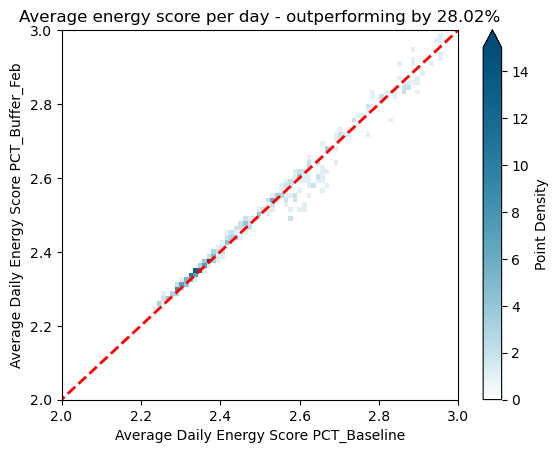

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

df_avg = energy_scores.groupby('date').mean()
technique_A = df_avg.iloc[:, 1]
technique_B = df_avg.iloc[:, 3]

# Increase bin size for a smoother heatmap
bin_size = 150

# Define the end color (#1D8DB0)
end_color = [0.114, 0.553, 0.690]  # RGB values

# Create a custom colormap starting from white to the end color with increased saturation
cmap_white_to_custom = LinearSegmentedColormap.from_list('white_to_custom', [(1, 1, 1), end_color], N=256)

# Create a modified colormap with increased saturation
cmap_white_to_custom_saturation = ListedColormap(cmap_white_to_custom(np.linspace(0, 1, 256))[:, :3] ** 2)

# Use the custom colormap in hist2d
heatmap = plt.hist2d(technique_A, technique_B, bins=bin_size, cmap=cmap_white_to_custom_saturation)

# Add a 45-degree line
plt.plot([0, 3], [0, 3], color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Average Daily Energy Score PCT_Baseline')
plt.ylabel('Average Daily Energy Score PCT_Buffer_Feb')
percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
plt.title(f'Average energy score per day - outperforming by {percentage_A_greater_than_B:.2f}%')

# Add colorbar with white indicating zero density
cbar = plt.colorbar(heatmap[3], label='Point Density', cmap=cmap_white_to_custom_saturation, extend='max')

plt.xlim(2,3)
plt.ylim(2,3)
# Show the plot
plt.savefig('pictures/irelanddailycomparison.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

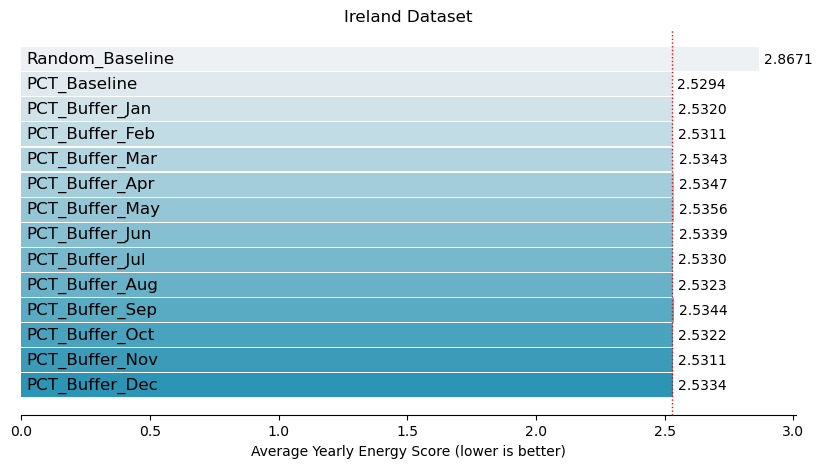

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Mock example data
techniques = ['Random_Baseline', 'PCT_Baseline']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a new list with entries for each month
extended_list = [f'PCT_Buffer_{month}' for month in months]
values = []
values.extend(energy_scores.mean(axis = 0).values.tolist())
techniques.extend(extended_list)

# Define a list of colors (include more than 4 colors for potential future use)
base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)

# Use the first four colors for the current bars
#bar_colors = all_colors[:len(techniques)]

# Calculate positions for bars
bar_positions = np.arange(len(techniques))

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.2  # Adjust the width of the bars
bar_spacing = 0.01  # Adjust the spacing between the bars

bars = ax.barh(bar_positions * (bar_width + bar_spacing), values, color=palette, height=bar_width)

# Adding values and standard deviations at the end of each bar
for bar, technique, value,  in zip(bars, techniques, values):
    decimals = 4 if str(value)[::-1].find('.') >= 2 else 2
    value_text = f'{value:.{decimals}f}'
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar_width / 2, value_text, ha='left', va='center', fontsize=10, color='black')
    ax.text(bar.get_x() + 0.02, bar.get_y() + bar_width / 2, technique, ha='left', va='center', fontsize=12, color='black')

# Add a thin dotted red vertical line at the value of index 1 in the values list
ax.axvline(x=values[1], color='red', linestyle=':', linewidth=1)

# Customize plot
ax.set_yticks([])  # Remove y-axis ticks
ax.invert_yaxis()  # Invert y-axis to have the first technique at the top

# Remove box edges
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set labels and title
ax.set_xlabel('Average Yearly Energy Score (lower is better)')
ax.set_title('Ireland Dataset')
plt.savefig('pictures/energy_score_comparison_ireland.png', bbox_inches='tight', dpi=300, transparent=True)
# Show plot
plt.show()


In [25]:
import pandas as pd
# Drop the first column by using its index as randombaseline should not be included
energy_scores = energy_scores.drop(energy_scores.columns[0], axis=1)
# Assuming energy_scores is your DataFrame

# Convert the index to a datetime object
energy_scores.index = pd.to_datetime(energy_scores.index)

# Extract the month from the datetime index
energy_scores['Month'] = energy_scores.index.month

# Initialize an empty DataFrame for the final table
monthly_means = pd.DataFrame()

# Calculate the mean for each month for each column
for month in range(1, 13):
    monthly_mean = energy_scores[energy_scores['Month'] == month].mean()
    monthly_means[month] = monthly_mean

# Drop the 'Month' row as it's not needed in the final table
monthly_means = monthly_means.drop('Month')

# Rename the index for clarity
monthly_means.index = ['PCT_Baseline', 'PCT_Buffer_Jan', 'PCT_Buffer_Feb', 'PCT_Buffer_Mar', 'PCT_Buffer_Apr', 'PCT_Buffer_May', 'PCT_Buffer_Jun', 'PCT_Buffer_Jul', 'PCT_Buffer_Aug', 'PCT_Buffer_Sep', 'PCT_Buffer_Oct', 'PCT_Buffer_Nov', 'PCT_Buffer_Dec']

# Rename the columns to represent months
monthly_means.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Display the table
display(monthly_means)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline,2.810306,2.693744,2.549892,2.448533,2.400162,2.329207,2.362360,2.390268,2.411425,2.451444,2.569179,2.941332
PCT_Buffer_Jan,2.758096,2.685577,2.554214,2.454195,2.407623,2.338109,2.370926,2.396089,2.419272,2.460583,2.584214,2.960010
PCT_Buffer_Feb,2.782672,2.641615,2.544135,2.452182,2.405881,2.338807,2.372631,2.397270,2.416625,2.458746,2.589135,2.974543
PCT_Buffer_Mar,2.804800,2.673592,2.535221,2.451495,2.405245,2.339310,2.373179,2.397953,2.417806,2.458230,2.590443,2.966748
PCT_Buffer_Apr,2.817694,2.698308,2.547110,2.437978,2.400678,2.333711,2.367491,2.394633,2.416476,2.453004,2.591073,2.962533
PCT_Buffer_May,2.820892,2.699183,2.554310,2.441499,2.385068,2.336114,2.373019,2.395253,2.414446,2.454821,2.593499,2.963591
PCT_Buffer_Jun,2.819421,2.704027,2.560071,2.449769,2.395435,2.312396,2.362274,2.388611,2.410451,2.457791,2.591283,2.960363
PCT_Buffer_Jul,2.822038,2.705059,2.562831,2.453395,2.403826,2.321174,2.336604,2.380956,2.412820,2.457628,2.587203,2.958200
PCT_Buffer_Aug,2.814992,2.698765,2.562404,2.454002,2.406516,2.326658,2.350164,2.363778,2.413860,2.457368,2.592625,2.953055
PCT_Buffer_Sep,2.820811,2.702789,2.562460,2.454327,2.400948,2.330662,2.361687,2.382153,2.392305,2.452488,2.595253,2.962156


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming monthly_means is your DataFrame after calculating the means

# Function to normalize data and apply color gradient within each column
def color_gradient(val, min_val, max_val, base_val):
    dif_lower = base_val - min_val
    dif_higher = max_val - base_val
    if dif_lower < dif_higher:
        min_val -= (dif_higher - dif_lower)
    elif dif_higher < dif_lower:
        max_val += (dif_lower - dif_higher)
    
    # Normalize the value within the column
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    # Use RdYlGn colormap (Red to Green)
    color = plt.cm.RdYlGn_r(norm(val))  # _r reverses the colormap
    # Convert color to hex format
    return f'background-color: {mcolors.to_hex(color)}; color: black'

# Function to round values, apply color gradient, and conditionally bold text
def apply_style(x):
    base_val = x[0]  # Assuming the first value is the baseline
    styled_cells = []
    for v in x:
        style = color_gradient(v, min(x), max(x), base_val)
        if v < base_val:
            style += '; font-weight: bold'
        styled_cells.append(f'{style}; text-align: right')
    return styled_cells

# Apply the color mapping and rounding to each cell within its column
styled_table = (monthly_means
                .round(5)
                .style
                .apply(apply_style, axis=0)
                .format("{:.5f}")
                .set_caption("<b style='font-size:15px;'>Average Monthly Energy Score Per Model (Rows) Per Month (Columns) With PCT_Baseline Comparison</b>"))

# Display the styled table
styled_table


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline,2.81031,2.69374,2.54989,2.44853,2.40016,2.32921,2.36236,2.39027,2.41142,2.45144,2.56918,2.94133
PCT_Buffer_Jan,2.75810,2.68558,2.55421,2.45420,2.40762,2.33811,2.37093,2.39609,2.41927,2.46058,2.58421,2.96001
PCT_Buffer_Feb,2.78267,2.64161,2.54414,2.45218,2.40588,2.33881,2.37263,2.39727,2.41662,2.45875,2.58913,2.97454
PCT_Buffer_Mar,2.80480,2.67359,2.53522,2.45150,2.40524,2.33931,2.37318,2.39795,2.41781,2.45823,2.59044,2.96675
PCT_Buffer_Apr,2.81769,2.69831,2.54711,2.43798,2.40068,2.33371,2.36749,2.39463,2.41648,2.45300,2.59107,2.96253
PCT_Buffer_May,2.82089,2.69918,2.55431,2.44150,2.38507,2.33611,2.37302,2.39525,2.41445,2.45482,2.59350,2.96359
PCT_Buffer_Jun,2.81942,2.70403,2.56007,2.44977,2.39543,2.31240,2.36227,2.38861,2.41045,2.45779,2.59128,2.96036
PCT_Buffer_Jul,2.82204,2.70506,2.56283,2.45340,2.40383,2.32117,2.33660,2.38096,2.41282,2.45763,2.58720,2.95820
PCT_Buffer_Aug,2.81499,2.69877,2.56240,2.45400,2.40652,2.32666,2.35016,2.36378,2.41386,2.45737,2.59263,2.95306
PCT_Buffer_Sep,2.82081,2.70279,2.56246,2.45433,2.40095,2.33066,2.36169,2.38215,2.39230,2.45249,2.59525,2.96216
